In [45]:
import pandas as pd
filename = 'generic_ratios_by_chemical_3.csv'
try:
    df = pd.read_csv(filename)
except IOError:
    sql = """WITH
      num AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        COUNT(*) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      WHERE
        bnf_code LIKE '_________AA%'
      GROUP BY
        month,
        product),
      denom AS (
      SELECT
        month,
        SUBSTR(bnf_code, 0, 9) AS product,
        COUNT(*) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard`
      --WHERE
      --  bnf_code LIKE '0%'
      GROUP BY
        month,
        product
      HAVING
        COUNT(*) > 100),
      data AS (
      SELECT
        num.month,
        num.product,
        num.items / denom.items AS value
      FROM
        num
      INNER JOIN
        denom
      ON
        num.month = denom.month
        AND num.product = denom.product ),
      data_with_stats AS (
      SELECT
        DISTINCT month,
        product,
        value,
        LAST_VALUE(value) OVER (PARTITION BY product ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) - FIRST_VALUE(value) OVER (PARTITION BY product ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS delta,
        ABS(PERCENTILE_CONT(value,
            0.75) OVER (PARTITION BY product) - PERCENTILE_CONT(value,
            0.25) OVER (PARTITION BY product)) AS iqr
      FROM
        data )
    SELECT
      bnf.chemical AS product_name,
      data_with_stats.*
    FROM
      data_with_stats
    INNER JOIN 
      (SELECT DISTINCT chemical, chemical_code FROM `ebmdatalab.hscic.bnf`) bnf 
    ON
      bnf.chemical_code = data_with_stats.product
      """
    df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')
    df.to_csv(filename)

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


In [43]:
sql = """WITH
  num AS (
  SELECT
    month,
    COUNT(*) AS items,
    SUM(actual_cost) AS actual_cost
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
  WHERE
    bnf_code LIKE '_________AA%'
  GROUP BY
    month),
  denom AS (
  SELECT
    month,
    COUNT(*) AS items,
    SUM(actual_cost) AS actual_cost
  FROM
    `ebmdatalab.hscic.normalised_prescribing_standard`
  --WHERE
  --  bnf_code LIKE '0%'
  GROUP BY
    month)
SELECT
  num.month,
  num.items / denom.items AS items_percent,
  num.actual_cost / denom.actual_cost AS act_cost_percent
FROM
  num
INNER JOIN
  denom
ON
  num.month = denom.month"""
top_df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


# Overall generic prescribing

The following chart shows that the proportion of prescriptions made generically has dropped a very small amount over the last 8 years; the proportion of spending which has been prescribed generically has dropped a lot more.



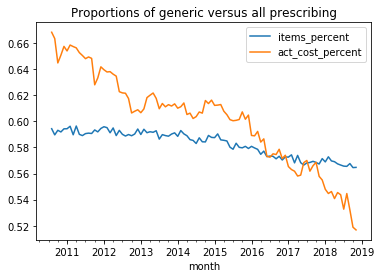

In [44]:
top_df = top_df.sort_values('month')
top_df.set_index('month').plot.line(title="Proportions of generic versus all prescribing")

# Which are the chemicals showing the greatest positive and negative changes?

In [47]:
most_variance = df.groupby('product').min().reset_index().sort_values('iqr', ascending=False).head(50)

In [48]:
most_variance

,product,product_name,month,value,delta,iqr
1226,1404000L0,Pneumococcal,2010-08-01,0.001144,0.989533,0.980589
1031,1201010F0,Flumetasone Pivalate,2010-08-01,0.353362,0.620112,0.589994
309,0310000Q0,Phenylephrine Hydrochloride,2010-08-01,0.049524,0.465328,0.467012
952,1103010H0,Fusidic Acid,2010-08-01,0.521877,0.466625,0.434373
661,0603020L0,Hydrocortisone Sodium Phosphate,2010-08-01,0.452970,0.534442,0.429567
1032,1201010G0,Hydrocortisone Acetate,2010-08-01,0.506443,0.459850,0.422479
518,0411000F0,Galantamine,2010-08-01,0.403165,-0.492709,0.412438
273,0303010Q0,Sodium Cromoglicate,2010-08-01,0.182390,0.464578,0.387960
655,0603020C0,Betamethasone Sodium Phosphate,2010-08-01,0.585196,0.393306,0.361807
475,0408010Q0,Phenytoin Sodium,2010-08-01,0.630377,0.363937,0.356303


# Chemicals being prescribed more and more as generics

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


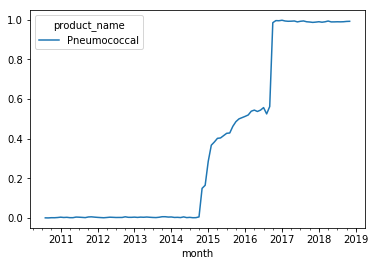

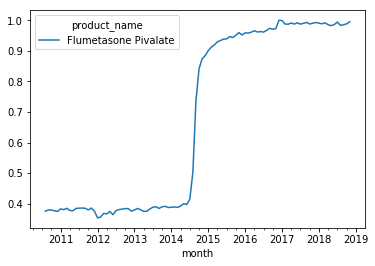

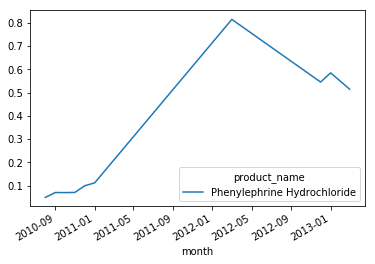

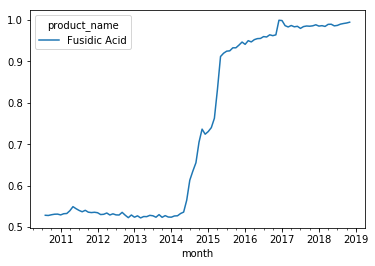

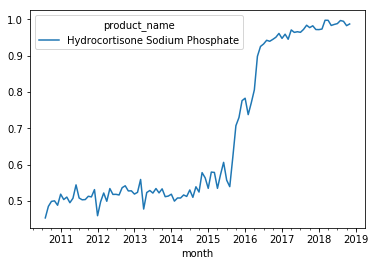

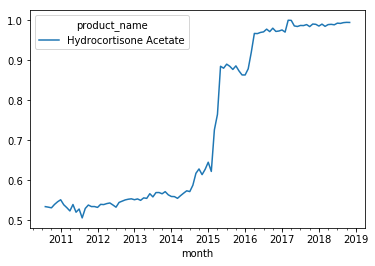

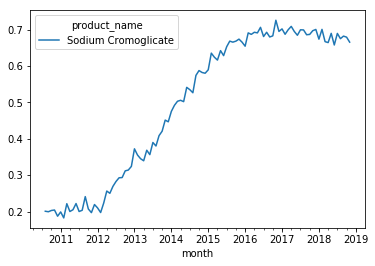

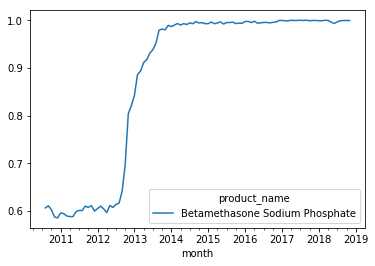

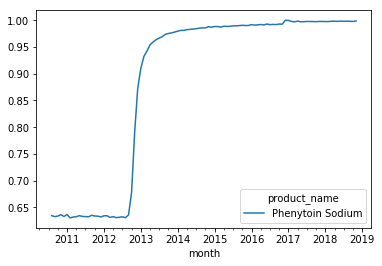

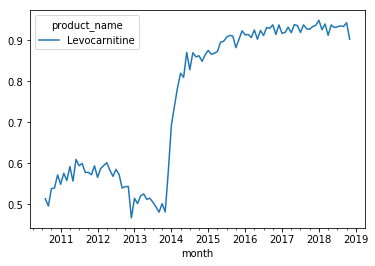

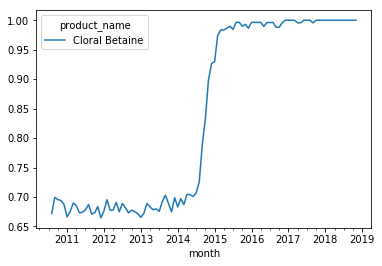

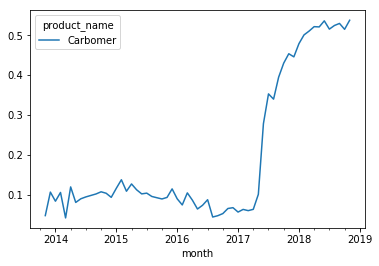

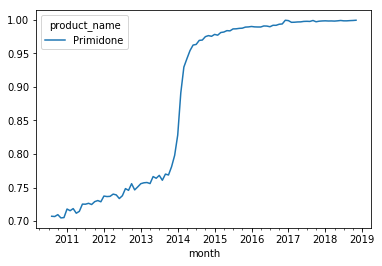

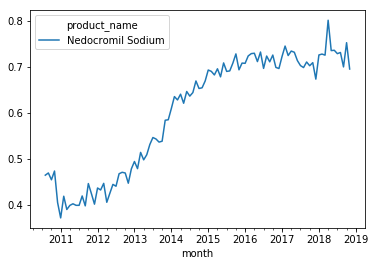

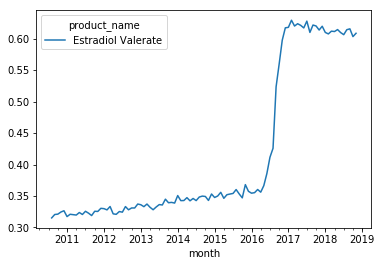

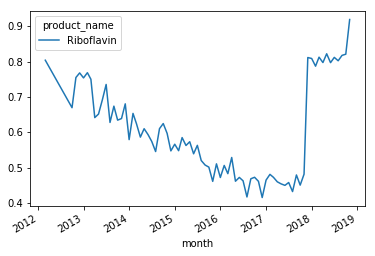

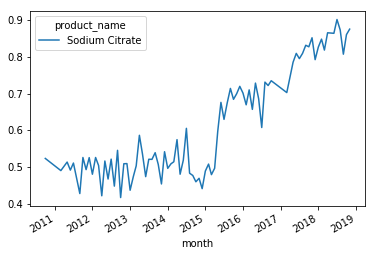

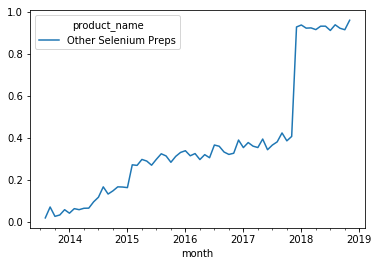

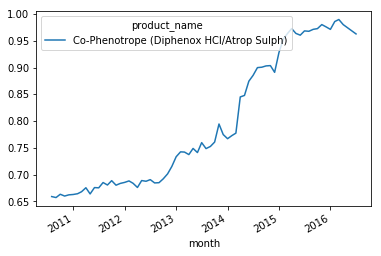

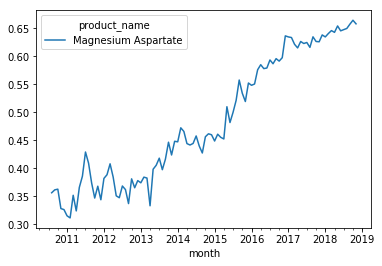

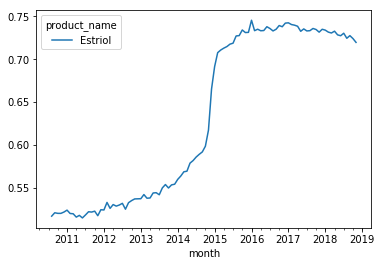

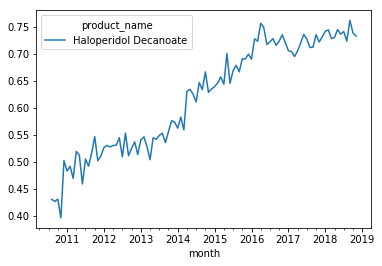

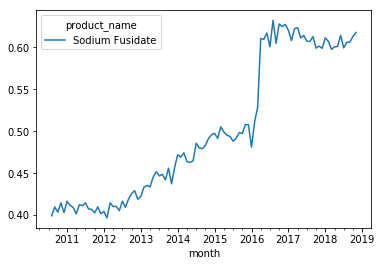

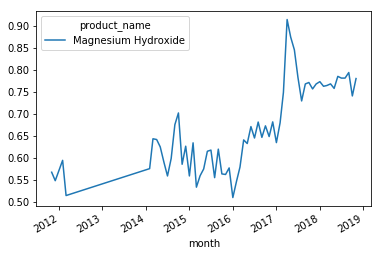

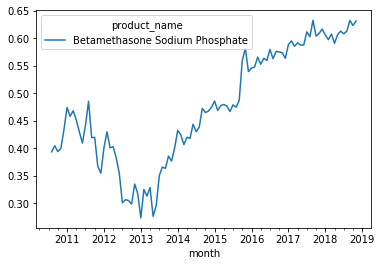

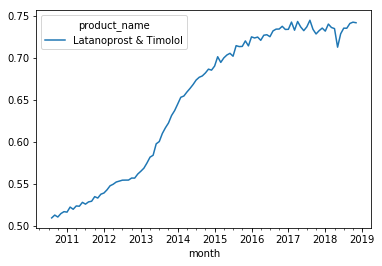

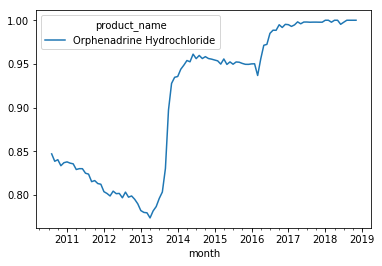

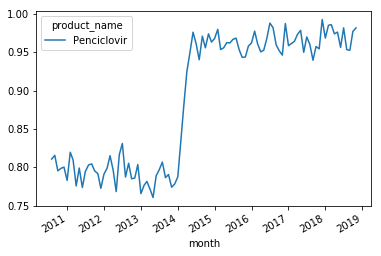

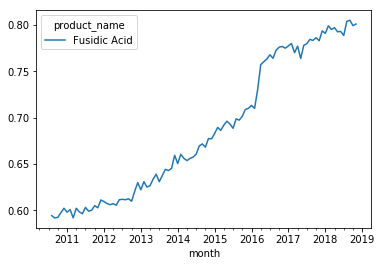

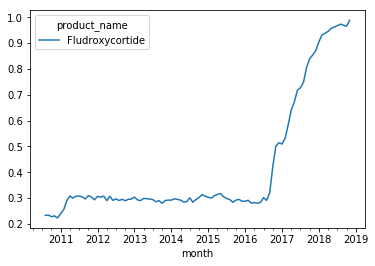

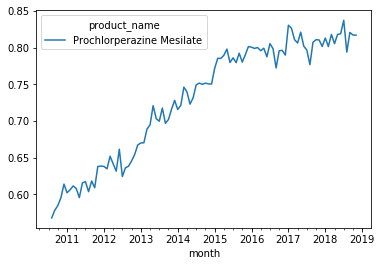

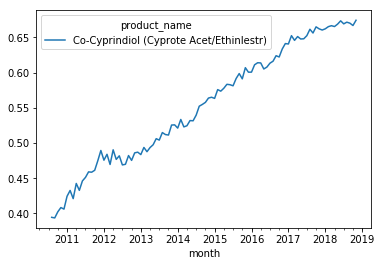

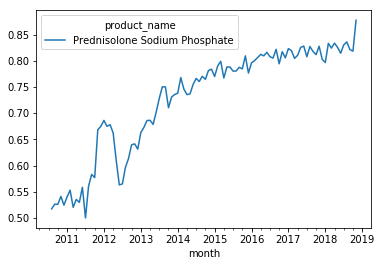

In [49]:
%matplotlib inline
for product in most_variance[most_variance['delta'] > 0]['product']:
    df[df['product'] == product].groupby(['month', 'product_name']).sum().value.unstack().plot.line()


# Chemicals being prescribed less and less as generics


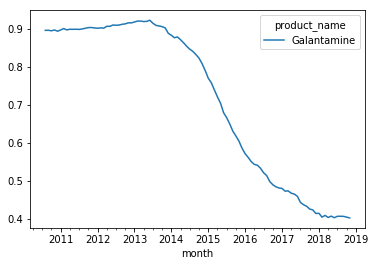

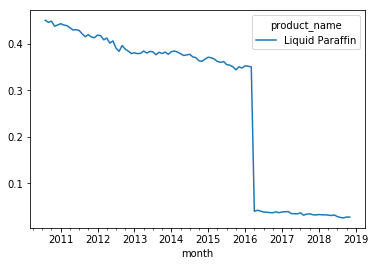

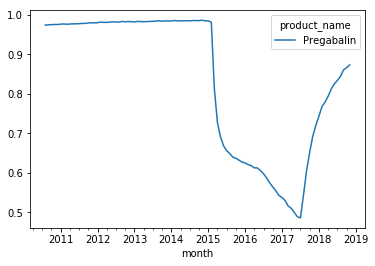

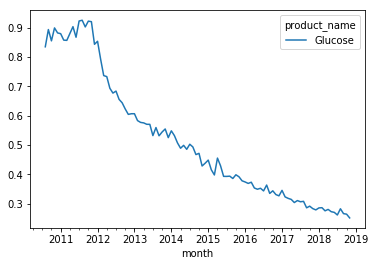

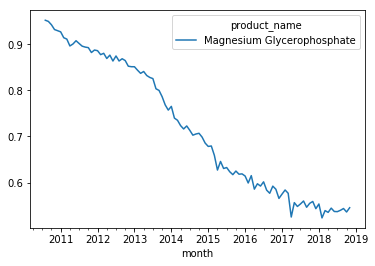

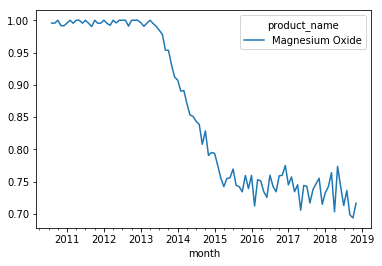

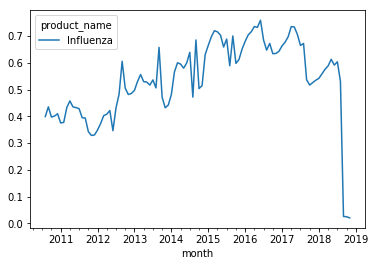

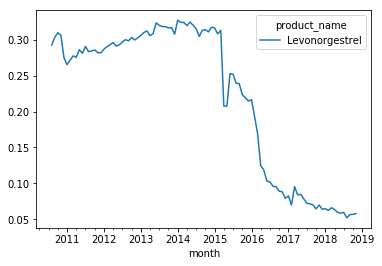

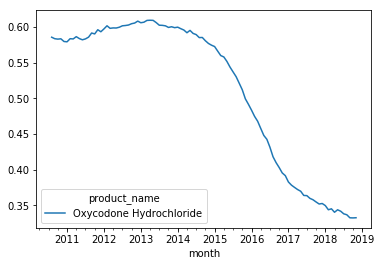

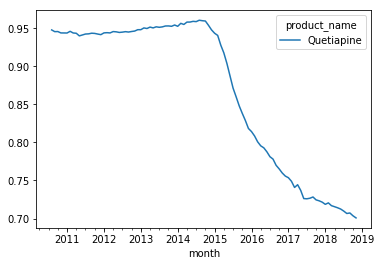

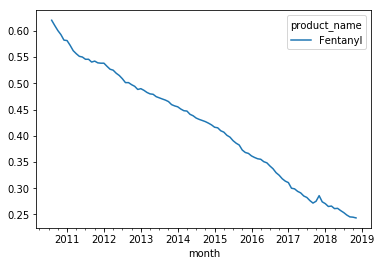

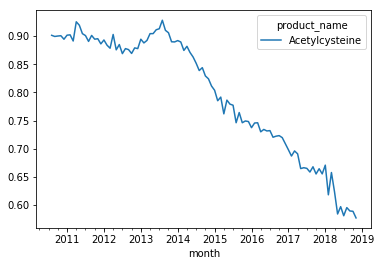

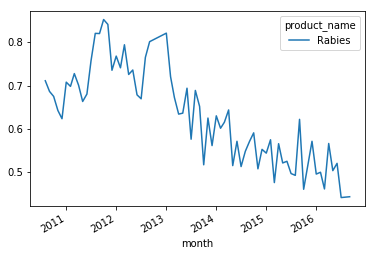

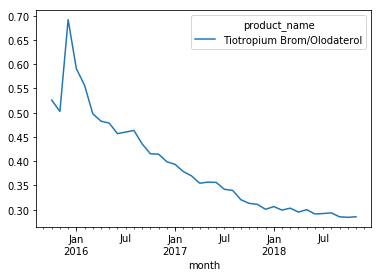

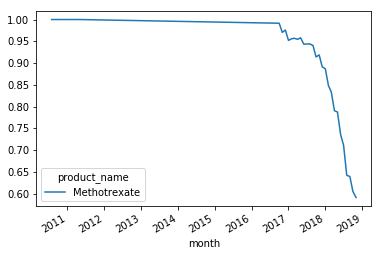

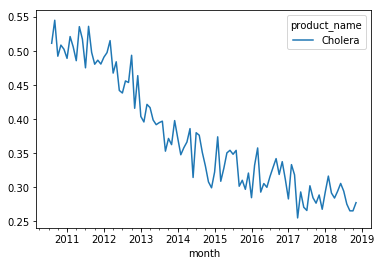

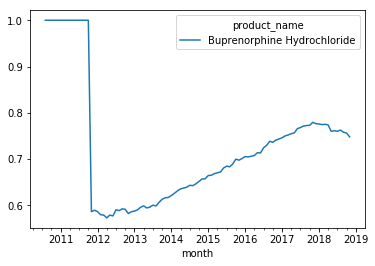

In [50]:
%matplotlib inline
for product in most_variance[most_variance['delta'] < 0]['product']:
    df[df['product'] == product].groupby(['month', 'product_name']).sum().value.unstack().plot.line()
